### Import required Libraries

In [129]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing;
import math, time, itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os
from sklearn import linear_model;
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf 

### Load Dataset

In [130]:
df = pd.read_csv("./dataset/prices-split-adjusted.csv", index_col = 0)

### Select a company for which we'll be predicting stock prices

In [131]:
df = df[df['symbol'] == 'SYMC']
df['Mid']=(df['high']+df['low'])/2
df.sort_values(by='date',inplace=True)

### Prepare Train and Test Dataset

In [132]:
def prepare_data(df,forecast_col,forecast_out,test_size):
    label = df[forecast_col].shift(-forecast_out);
    X = np.array(df[[forecast_col]]); 
    X = preprocessing.scale(X) 
    X_lately = X[-forecast_out:] 
    X = X[:-forecast_out] 
    label.dropna(inplace=True); 
    y = np.array(label) 
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_size) #cross validation 

    response = [X_train,X_test , Y_train, Y_test , X_lately];
    return response;

### Prepare Dataset and add a new column, Mid = (low + high)/2 to the data

In [133]:
target_col = 'Mid'
predict_window = 20
test_size = 0.2;

X_train, X_test, Y_train, Y_test , X_lately =prepare_data(df, target_col, predict_window, test_size); 

# Model 1: Linear Regression

In [134]:
linear_reg_model = linear_model.LinearRegression(); 

The test score is:  0.8488507471454791


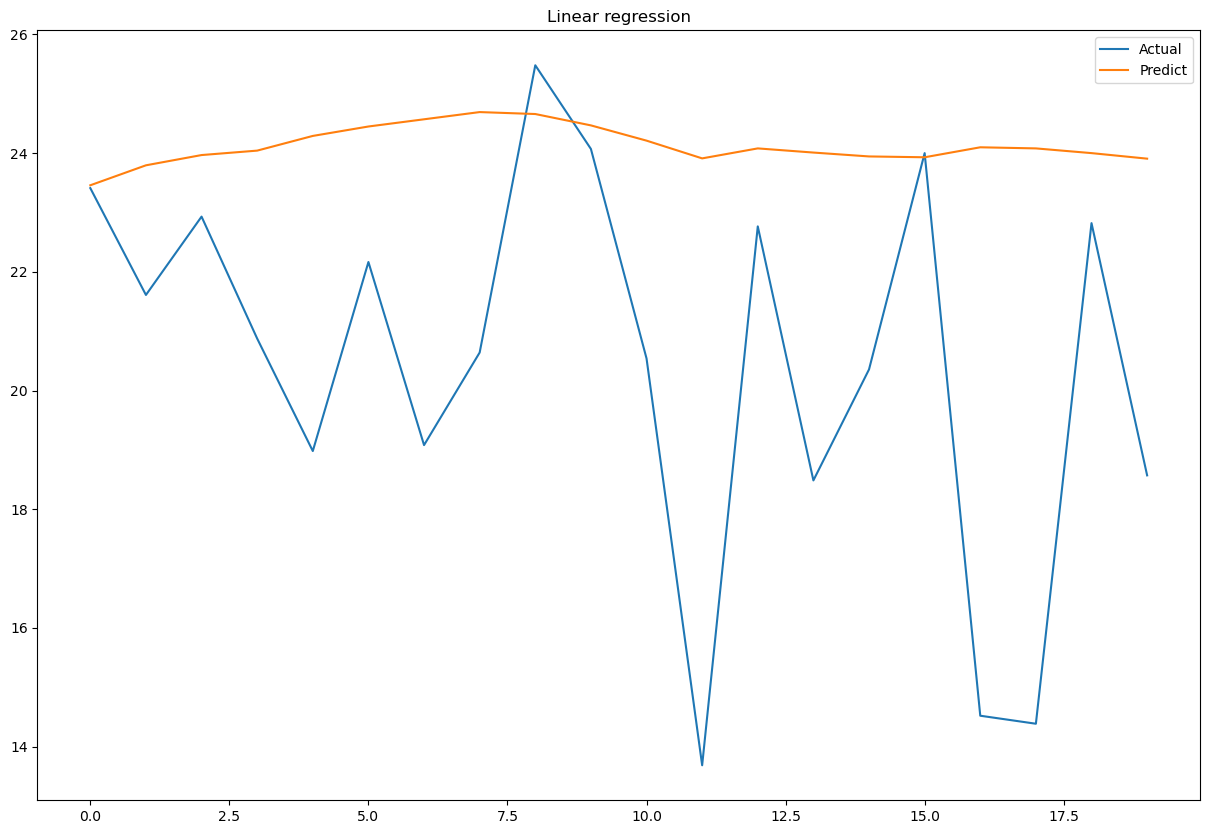

In [135]:
linear_reg_model.fit(X_train,Y_train); 
score = linear_reg_model.score(X_test,Y_test);

predicted= linear_reg_model.predict(X_lately); 

response={};
response['test_score']=score; 
response['predicted_set']=predicted;
print("The test score is: ",format(score))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
ax.plot(Y_test[:predict_window],label='Actual')
ax.plot(predicted,label='Predict')
plt.title('Linear regression')
ax.legend()

# Model 2 - Standard Average

### Prepare Dataset

In [136]:
train_start = 0
train_end=1000
test_start = train_end
n= df.shape[0]
test_end = n
data_train = df.iloc[np.arange(train_start, train_end), :]
data_test = df.iloc[np.arange(test_start, test_end), :]

data_train=data_train.reset_index()
data_test=data_test.reset_index()

scaler = MinMaxScaler()
training_val=scaler.fit_transform(data_train['Mid'].to_numpy().reshape(-1,1))
test_val=scaler.transform(data_test['Mid'].to_numpy().reshape(-1,1))

In [137]:
data_train.head()

,date,symbol,open,close,low,high,volume,Mid
0,2010-01-04,SYMC,18.040001,18.400000,18.010000,18.530001,8322300.0,18.270001
1,2010-01-05,SYMC,18.400000,18.299999,18.139999,18.440001,6621200.0,18.290000
2,2010-01-06,SYMC,18.219999,18.360001,18.139999,18.459999,6043600.0,18.299999
3,2010-01-07,SYMC,18.469999,18.320000,18.129999,18.469999,8085300.0,18.299999
4,2010-01-08,SYMC,18.250000,18.370001,18.209999,18.500000,6030900.0,18.354999


In [123]:
window_size = 75
N = training_val.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.index.values[pred_idx]

    std_avg_predictions.append(np.mean(training_val[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-training_val[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00611


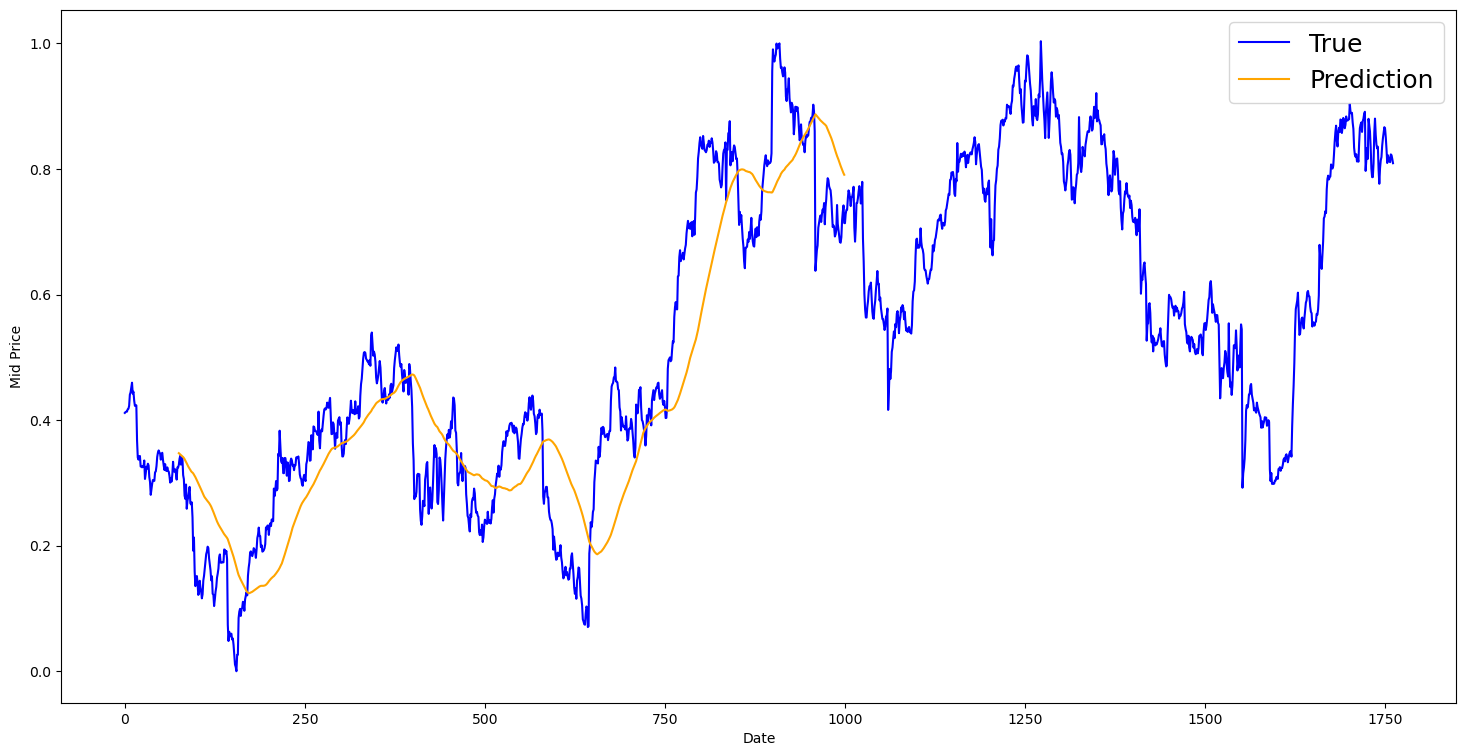

In [124]:
all_mid_data = np.concatenate([training_val,test_val],axis=0)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Model 3 - Exponential moving average

In [138]:
window_size = 100
N = training_val.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*training_val[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-training_val[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00031


C:\Users\ganga\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


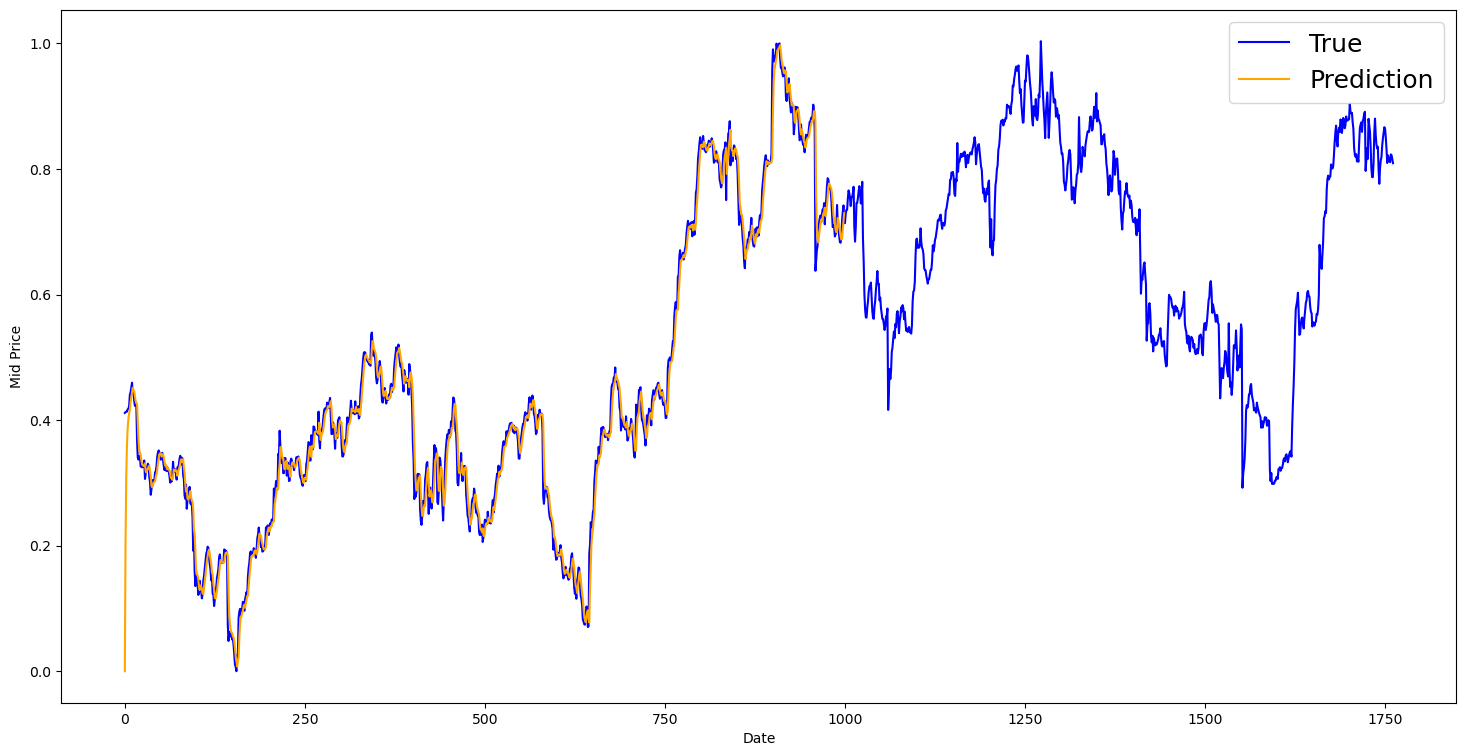

In [139]:
all_mid_data = np.concatenate([training_val,test_val],axis=0)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()